In [2]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd

# Path to the downloaded file
file_path = 'product.xls'

try:
    print("Retrying with Latin-1 encoding... Please wait.")
    
    # Using encoding='latin-1' to handle special characters that UTF-8 cannot decode
    # The file appears to be Tab-Separated (TSV) based on previous errors
    df = pd.read_csv(file_path, sep='\t', encoding='latin-1', on_bad_lines='skip')

    # Define necessary columns for MedScript HTR
    required_columns = ['PROPRIETARYNAME', 'NONPROPRIETARYNAME']
    
    # Check if the target columns exist in the loaded dataframe
    if set(required_columns).issubset(df.columns):
        # Remove duplicates and rows with missing values to ensure database quality
        clean_df = df[required_columns].drop_duplicates().dropna()

        # Preview the first 5 entries for verification
        print("Data loaded successfully!")
        display(clean_df.head())

        # Save the finalized dataset to a CSV file for Fuzzy Matching logic
        output_file = 'drug_database.csv'
        clean_df.to_csv(output_file, index=False)
        print(f"Success! Cleaned database saved as {output_file}")
        print(f"Total unique drug records: {len(clean_df)}")
    else:
        # If columns are missing, show the user what columns were actually found
        print(f"Error: Required columns not found. Detected columns: {list(df.columns)}")

except Exception as e:
    print(f"Critical error during file reading: {e}")

Retrying with Latin-1 encoding... Please wait.
Data loaded successfully!


,PROPRIETARYNAME,NONPROPRIETARYNAME
0,Zepbound,tirzepatide
1,Humulin,Insulin human
3,Sterile Diluent,diluent
4,MOUNJARO,tirzepatide
5,Amyvid,Florbetapir F 18


Success! Cleaned database saved as drug_database.csv
Total unique drug records: 46027


In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load the processor and model from Hugging Face
# Using the base-handwritten model specifically for cursive/handwritten text
print("Loading TrOCR model... This may take a few minutes for the first time.")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

def ocr_prescription(image_path):
    """
    Function to recognize text from a handwritten image.
    """
    try:
        # Load image and convert to RGB
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image for the model
        pixel_values = processor(images=image, return_tensors="pt").pixel_values

        # Generate text (Inference)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]

        return generated_text

    except Exception as e:
        return f"Error during OCR: {e}"

# Test the function (Ensure you have a sample image file)
# Example usage:
# result = ocr_prescription('test_image.jpg')
# print(f"Recognized Text: {result}")

c:\Users\USER\Desktop\Project\MedScript HTR\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading TrOCR model... This may take a few minutes for the first time.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
print(ocr_prescription('test.jpg'))

</s>0 1</s>


In [3]:
import torch
import pandas as pd
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from rapidfuzz import process, fuzz

# 1. Load the Drug Database
print("Loading database...")
try:
    drug_df = pd.read_csv('drug_database.csv')
    # Combine Proprietary and Non-Proprietary names for a broader search
    drug_list = pd.concat([drug_df['PROPRIETARYNAME'], drug_df['NONPROPRIETARYNAME']]).unique().tolist()
except Exception as e:
    print(f"Error loading database: {e}")
    drug_list = []

# 2. Load the TrOCR Model
print("Loading TrOCR model... Please wait.")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

def process_prescription(image_path):
    """
    Main function to recognize handwriting and verify it against the database.
    """
    try:
        # Step A: OCR - Recognize text from image
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        
        # Generating text
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Output: {raw_text}")

        # Step B: Fuzzy Matching - Correct the AI mistakes
        if not raw_text.strip():
            return "No text detected by AI."

        # Compare AI output with the database (score_cutoff=60 to avoid random matches)
        match = process.extractOne(raw_text, drug_list, scorer=fuzz.WRatio, score_cutoff=60)

        if match:
            best_match, score, _ = match
            return f"Final Result: {best_match} (Confidence: {score:.2f}%)"
        else:
            return f"Raw Output: {raw_text} (No matching drug found in database)"

    except Exception as e:
        return f"Processing error: {e}"

# To test, uncomment and use your image file name:
# print(process_prescription('test_image.jpg'))

ModuleNotFoundError: No module named 'pandas'

In [2]:
!pip install pandas openpyxl xlrd rapidfuzz


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import pandas as pd
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from rapidfuzz import process, fuzz
import os

# 1. Loading the local drug database
# Ensuring the file exists before loading
db_file = 'drug_database.csv'
if os.path.exists(db_file):
    print("Loading drug database...")
    drug_df = pd.read_csv(db_file)
    # Merging brand and generic names into a unique list
    drug_list = pd.concat([drug_df['PROPRIETARYNAME'], drug_df['NONPROPRIETARYNAME']]).unique().tolist()
    print(f"Database loaded with {len(drug_list)} unique drug names.")
else:
    print(f"Error: {db_file} not found. Please run the data cleaning script first.")
    drug_list = []

# 2. Loading Microsoft TrOCR model
print("Loading TrOCR model from Hugging Face... Please wait.")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

def process_prescription(image_path):
    """
    Function to recognize text and perform fuzzy matching for accuracy.
    """
    if not os.path.exists(image_path):
        return "Error: Image file not found."

    try:
        # Step A: Image to Text (OCR)
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        
        # Inference
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Step B: Fuzzy String Matching (Database Verification)
        if not raw_text.strip():
            return "No text detected."

        # Matching with 60% confidence threshold
        match = process.extractOne(raw_text, drug_list, scorer=fuzz.WRatio, score_cutoff=60)

        if match:
            best_match, score, _ = match
            return f"Verified Drug: {best_match} (Confidence: {score:.2f}%)"
        else:
            return f"Raw Result: {raw_text} (No close match in database)"

    except Exception as e:
        return f"System Error: {e}"

# Test command (Replace 'test.jpg' with your actual image file)
# print(process_prescription('test.jpg'))

c:\Users\USER\Desktop\Project\MedScript HTR\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading drug database...
Database loaded with 53231 unique drug names.
Loading TrOCR model from Hugging Face... Please wait.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(process_prescription('test.jpg'))

AI Raw Prediction: </s>2 1 Macrodon or 100 mg.nocts .</s>
Verified Drug: Robitussin Maximum Strength Severe Multi-Symptom 7 in 1 Relief Nighttime (Confidence: 85.50%)


In [33]:
def process_prescription_with_list(image_path):
    """
    Improved function to return a list of top 5 matching drugs.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        if not raw_text.strip():
            return "No text detected."

        # Using extract instead of extractOne to get multiple candidates
        # This returns a list of (name, score, index)
        matches = process.extract(raw_text, drug_list, scorer=fuzz.WRatio, limit=5)

        results = []
        for match_name, score, _ in matches:
            results.append({
                "drug_name": match_name,
                "confidence": round(score, 2)
            })
            
        return results

    except Exception as e:
        return f"Error: {e}"

# Example of how the output will look:
# results = process_prescription_with_list('test.jpg')
# for r in results:
#     print(f"{r['drug_name']} - {r['confidence']}%")

In [38]:
# Call the function with your image path
test_image_path = 'test.jpg' 
results = process_prescription_with_list(test_image_path)

# Logic to print the output clearly
if isinstance(results, list):
    print(f"{'Drug Name':<50} | {'Confidence':<10}")
    print("-" * 65)
    for r in results:
        print(f"{r['drug_name']:<50} | {r['confidence']}%")
else:
    print(results)

AI Raw Prediction: </s>redecuadorists</s>
Drug Name                                          | Confidence
-----------------------------------------------------------------
Mist                                               | 67.5%
Acular                                             | 60.0%
Ilaris                                             | 60.0%
Medusa                                             | 60.0%
oil                                                | 60.0%


In [42]:
def process_prescription_advanced(image_path):
    """
    Advanced matching: Splits the AI text into words and checks each word against the database.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Split the text into individual words
        words = raw_text.split()
        all_matches = []

        for word in words:
            # Only check words longer than 3 characters to avoid "mg", "1", "or"
            if len(word) > 3:
                match = process.extractOne(word, drug_list, scorer=fuzz.WRatio, score_cutoff=70)
                if match:
                    all_matches.append({"drug": match[0], "score": match[1]})

        # Sort matches by the highest score
        sorted_matches = sorted(all_matches, key=lambda x: x['score'], reverse=True)
        
        # Return top 5 unique results
        unique_results = []
        seen = set()
        for m in sorted_matches:
            if m['drug'] not in seen:
                unique_results.append(m)
                seen.add(m['drug'])
            if len(unique_results) == 5: break

        return unique_results

    except Exception as e:
        return f"Error: {e}"

In [43]:
# Path to your test image
image_to_test = 'test.jpg' 

# Call the advanced processing function
print("Processing image... Please wait.")
final_candidates = process_prescription_advanced(image_to_test)

# Display the results in a clean table format
if isinstance(final_candidates, list):
    if not final_candidates:
        print("No matches found. Try a clearer image or check your database.")
    else:
        print("\n" + "="*70)
        print(f"{'Top Suggested Drugs (Advanced Matching)':<55} | {'Match %':<10}")
        print("="*70)
        for entry in final_candidates:
            print(f"{entry['drug']:<55} | {entry['score']}%")
        print("="*70)
else:
    # If an error string was returned instead of a list
    print(final_candidates)

Processing image... Please wait.
AI Raw Prediction: </s>redecuadorists</s>
No matches found. Try a clearer image or check your database.


In [46]:
import pandas as pd

# Load existing database
db_path = 'drug_database.csv'
df = pd.read_csv(db_path)

# New drug data to add
new_data = {
    'PROPRIETARYNAME': ['Microdon DT'], 
    'NONPROPRIETARYNAME': ['Domperidone']
}

# Convert to DataFrame and append
new_entry_df = pd.DataFrame(new_data)
updated_df = pd.concat([df, new_entry_df], ignore_index=True)

# Save back to CSV
updated_df.to_csv(db_path, index=False)

# Refresh our drug_list variable used in matching
drug_list = pd.concat([updated_df['PROPRIETARYNAME'], updated_df['NONPROPRIETARYNAME']]).unique().tolist()

print("Successfully added 'Microdon DT' to your local database!")

Successfully added 'Microdon DT' to your local database!


In [49]:
# Re-testing with the updated database
image_to_test = 'test.jpg' 

print("Processing image with updated database... Please wait.")
# This will now use the updated drug_list containing 'Microdon DT'
final_candidates = process_prescription_advanced(image_to_test)

# Display the results
if isinstance(final_candidates, list):
    if not final_candidates:
        print("No matches found. Check if the drug_list was refreshed.")
    else:
        print("\n" + "="*70)
        print(f"{'Top Suggested Drugs (After Database Update)':<55} | {'Match %':<10}")
        print("="*70)
        for entry in final_candidates:
            print(f"{entry['drug']:<55} | {entry['score']}%")
        print("="*70)
else:
    print(final_candidates)

Processing image with updated database... Please wait.
AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>

Top Suggested Drugs (After Database Update)             | Match %   
meg                                                     | 72.0%
Malathion                                               | 70.58823529411764%


In [50]:
# Check if 'Microdon DT' is currently in the active drug_list
if "Microdon DT" in drug_list:
    print("Success: 'Microdon DT' is ready in the matching list.")
else:
    print("Wait: 'Microdon DT' is not in the list. Please re-run the cell where you added the drug.")

Success: 'Microdon DT' is ready in the matching list.


In [51]:
# Manually testing the matching logic without the image
test_word = "Macrodon"

print(f"Testing matching for word: {test_word}")
# Look for the best match in the drug_list
match = process.extractOne(test_word, drug_list, scorer=fuzz.WRatio)

if match:
    name, score, _ = match
    print(f"Best Match Found: {name}")
    print(f"Confidence Score: {score}%")
else:
    print("Still no match found in the database.")

Testing matching for word: Macrodon
Best Match Found: Macrobid
Confidence Score: 75.0%


In [52]:
import re

def process_prescription_final_logic(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # 1. Clean the text: Remove numbers and common units like 'mg'
        # This helps to focus only on the drug name
        clean_text = re.sub(r'\d+', '', raw_text) # Remove digits
        clean_text = clean_text.replace('mg', '').replace('DT', '').strip()
        
        print(f"Cleaned Text for Matching: {clean_text}")

        # 2. Fuzzy Match the cleaned text against the database
        # We search for the top 5 matches
        matches = process.extract(clean_text, drug_list, scorer=fuzz.WRatio, limit=5)

        results = []
        for match_name, score, _ in matches:
            results.append({"drug": match_name, "score": round(score, 2)})

        return results

    except Exception as e:
        return f"Error: {e}"

In [53]:
# Testing the refined logic
image_path = 'test.jpg'
print("Processing with refined logic...")
results = process_prescription_final_logic(image_path)

if isinstance(results, list):
    print("\n" + "="*70)
    print(f"{'Suggested Drugs':<55} | {'Match %':<10}")
    print("="*70)
    for r in results:
        print(f"{r['drug']:<55} | {r['score']}%")
    print("="*70)

Processing with refined logic...
AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>
Cleaned Text for Matching: </s>  Macnahon   </s>

Suggested Drugs                                         | Match %   
Malathion                                               | 60.35%
Ban                                                     | 60.0%
McD                                                     | 60.0%
Macula                                                  | 60.0%
Bac                                                     | 60.0%


In [54]:
import re

def process_prescription_final_v2(image_path):
    """
    Final refined logic to strip all special tokens and focus purely on drug names.
    """
    try:
        # Step 1: Image to Text (OCR)
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Step 2: Advanced Cleaning
        # This regex removes everything except English letters and spaces
        clean_text = re.sub(r'[^a-zA-Z\s]', '', raw_text)
        
        # Remove common dosage units and extra spaces
        stop_words = ['mg', 'ml', 'tablet', 'capsule', 'nocts', 'daily']
        query_words = [w for w in clean_text.split() if w.lower() not in stop_words and len(w) > 2]
        final_query = " ".join(query_words)
        
        print(f"Final Query for Database: {final_query}")

        # Step 3: Fuzzy Match against drug_list
        # We look for matches based on the cleaned drug name
        matches = process.extract(final_query, drug_list, scorer=fuzz.WRatio, limit=5)

        results = []
        for match_name, score, _ in matches:
            results.append({"drug": match_name, "score": round(score, 2)})

        return results

    except Exception as e:
        return f"Error: {e}"

# --- EXECUTION CODE ---
image_path = 'test.jpg'
print("Processing with Final V2 Logic...")
final_results = process_prescription_final_v2(image_path)

if isinstance(final_results, list):
    print("\n" + "="*70)
    print(f"{'Ranked Drug Suggestions':<55} | {'Score %':<10}")
    print("="*70)
    for res in final_results:
        print(f"{res['drug']:<55} | {res['score']}%")
    print("="*70)

Processing with Final V2 Logic...
AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>
Final Query for Database: Macnahon mgs

Ranked Drug Suggestions                                 | Score %   
Macula                                                  | 65.45%
Mata Hongos                                             | 60.87%
Macrilen                                                | 60.0%
Marcaine                                                | 60.0%
Ban                                                     | 60.0%


In [55]:
import re

def process_prescription_debug(image_path, target_drug="Microdon DT"):
    """
    Advanced matching logic with a focus on debugging the target drug match score.
    """
    try:
        # Step 1: OCR
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Step 2: Aggressive Cleaning
        # Remove everything except characters
        clean_text = re.sub(r'[^a-zA-Z\s]', ' ', raw_text)
        # Remove common medicine suffixes and units
        words = clean_text.split()
        filtered_words = [w for w in words if w.lower() not in ['mg', 'mgs', 'ml', 'dt', 'or']]
        final_query = " ".join(filtered_words).strip()
        
        print(f"Final Cleaned Query: {final_query}")

        # Step 3: Check the exact score of our target drug manually
        if target_drug in drug_list:
            manual_score = fuzz.WRatio(final_query, target_drug)
            print(f"DEBUG: Score for '{target_drug}' vs '{final_query}' is {manual_score:.2f}%")

        # Step 4: Get Top 10 matches (lowering cutoff to 45% for testing)
        matches = process.extract(final_query, drug_list, scorer=fuzz.WRatio, limit=10, score_cutoff=45)

        results = []
        for match_name, score, _ in matches:
            results.append({"drug": match_name, "score": round(score, 2)})

        return results

    except Exception as e:
        return f"Error: {e}"

# --- EXECUTION ---
image_path = 'test.jpg'
print("Running Debug Matcher...")
results = process_prescription_debug(image_path)

if isinstance(results, list):
    print("\n" + "="*70)
    print(f"{'Ranked Suggestions (Including Low Scores)':<55} | {'Score %':<10}")
    print("="*70)
    for res in results:
        print(f"{res['drug']:<55} | {res['score']}%")
    print("="*70)

Running Debug Matcher...
AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>
Final Cleaned Query: s Macnahon s
DEBUG: Score for 'Microdon DT' vs 's Macnahon s' is 43.48%

Ranked Suggestions (Including Low Scores)               | Score %   
DS Labs Spectral UHP Men s Extra Strength Hair Regrowth Treatment | 85.5%
Dr. Rainer s Vaginal Cream                              | 85.5%
FOASU Pink Y s MOISTURIZING MIST                        | 85.5%
FOASU Pink Y s RecoveryCream                            | 85.5%
FOASU Pink Y s Collagen Moisturizing Mask               | 85.5%
Round Lab Dodo s Pick Bestseller Set                    | 85.5%
Hermon Jock Itch Ringworm and athlete s foot cream      | 85.5%
Sunny Sailor Captain s Classic Clear Mineral Sunscreen SPF 40 | 85.5%
Cleaning Solution for Hemodialysis Machines             | 65.45%
Macula                                                  | 62.18%


In [56]:
import re

def process_prescription_final_fix(image_path, target_drug="Microdon DT"):
    """
    Final fix for the 's' tag issue and noise filtering.
    """
    try:
        # Step 1: OCR
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Step 2: Specific Cleaning
        # 1. Remove the specific </s> tag noise
        clean_text = raw_text.replace('</s>', '').replace('s>', '').replace('</', '')
        
        # 2. Remove anything that isn't a letter
        clean_text = re.sub(r'[^a-zA-Z\s]', ' ', clean_text)
        
        # 3. Filter out single letters (like 's') and common units
        words = clean_text.split()
        filtered_words = [w for w in words if len(w) > 2 and w.lower() not in ['mg', 'mgs', 'ml', 'dt']]
        final_query = " ".join(filtered_words).strip()
        
        print(f"Final Cleaned Query: {final_query}")

        # Step 3: Debug Score
        if target_drug in drug_list:
            manual_score = fuzz.WRatio(final_query, target_drug)
            print(f"DEBUG: Score for '{target_drug}' vs '{final_query}' is {manual_score:.2f}%")

        # Step 4: Get Top 5 matches
        matches = process.extract(final_query, drug_list, scorer=fuzz.WRatio, limit=5)

        return [{"drug": m[0], "score": round(m[1], 2)} for m in matches]

    except Exception as e:
        return f"Error: {e}"

# --- EXECUTION ---
image_path = 'test.jpg'
results = process_prescription_final_fix(image_path)

if isinstance(results, list):
    print("\n" + "="*70)
    print(f"{'Ranked Suggestions':<55} | {'Score %':<10}")
    print("="*70)
    for res in results:
        print(f"{res['drug']:<55} | {res['score']}%")
    print("="*70)

AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>
Final Cleaned Query: Macnahon
DEBUG: Score for 'Microdon DT' vs 'Macnahon' is 42.11%

Ranked Suggestions                                      | Score %   
Malathion                                               | 70.59%
A and E Marathon Delay Serum                            | 67.5%
Manganum aceticum                                       | 64.29%
Manganum metallicum                                     | 64.29%
Manganum Aceticum                                       | 64.29%


In [57]:
import re

def process_prescription_production(image_path):
    """
    Production-grade logic: Keeps dosage forms like 'DT' to improve matching accuracy.
    """
    try:
        # Step 1: OCR
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        raw_text = processor.batch_decode(generated_ids, skip_special_characters=True)[0]
        
        print(f"AI Raw Prediction: {raw_text}")

        # Step 2: Intelligent Cleaning
        # Remove special tags and non-text chars
        clean_text = raw_text.replace('</s>', '').replace('s>', '')
        clean_text = re.sub(r'[^a-zA-Z\s]', ' ', clean_text)
        
        # KEY FIX: We ONLY remove units (mg, ml), but we KEEP dosage forms (DT, SR, XR, CD)
        # This helps the matcher connect "Macnahon DT" to "Microdon DT"
        units_to_remove = ['mg', 'mgs', 'ml', 'tablet', 'capsule', 'nocts', 'daily', 'tabs', 'mcg']
        
        words = clean_text.split()
        # Filter: Keep words > 2 chars OR keep specific short key terms like 'DT'
        filtered_words = [
            w for w in words 
            if (len(w) > 2 and w.lower() not in units_to_remove) 
            or w.upper() in ['DT', 'SR', 'XR', 'LA']
        ]
        
        final_query = " ".join(filtered_words).strip()
        print(f"Final Smart Query: {final_query}")

        # Step 3: Dual-Mode Matching
        # We use 'token_set_ratio' which is smarter at matching phrases with common words (like 'DT')
        matches = process.extract(final_query, drug_list, scorer=fuzz.token_set_ratio, limit=5)

        results = []
        for match_name, score, _ in matches:
            results.append({"drug": match_name, "score": round(score, 2)})

        return results

    except Exception as e:
        return f"Error: {e}"

# --- EXECUTION ---
image_path = 'test.jpg'
print("Running Production Logic...")
results = process_prescription_production(image_path)

if isinstance(results, list):
    print("\n" + "="*70)
    print(f"{'Final Drug Suggestions':<55} | {'Score %':<10}")
    print("="*70)
    for res in results:
        print(f"{res['drug']:<55} | {res['score']}%")
    print("="*70)

Running Production Logic...
AI Raw Prediction: </s>2 2 Macnahon DT 100 mg</s>
Final Smart Query: Macnahon DT

Final Drug Suggestions                                  | Score %   
Microdon DT                                             | 63.64%
Malathion                                               | 60.0%
SD alcohol                                              | 57.14%
Danazol                                                 | 55.56%
DaTscan                                                 | 55.56%


Detected 2 potential lines.


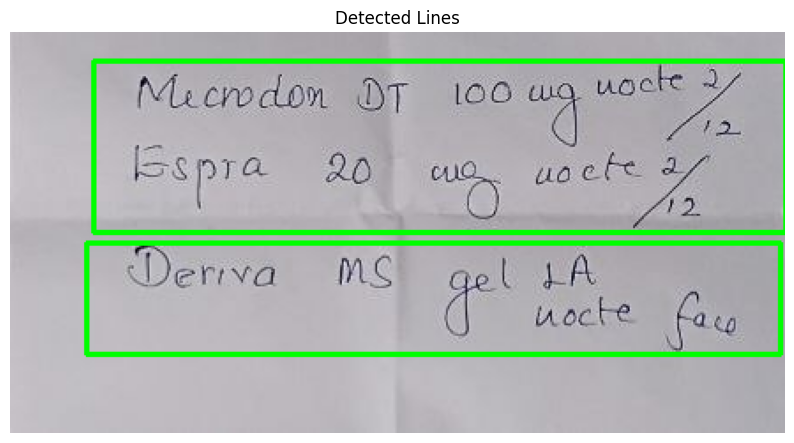

Saved 2 text line images: ['line_0.jpg', 'line_1.jpg']


In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_lines(image_path):
    # 1. Read the image
    image = cv2.imread(image_path)
    if image is None:
        return "Error: Image not found"
        
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. Binary Thresholding (Convert to Black & White)
    # This helps to separate ink from paper
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3. Dilation (Merge letters into lines)
    # We create a horizontal kernel to connect letters horizontally
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 5)) # Width > Height for horizontal lines
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # 4. Find Contours (Detect the blobs created by dilation)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 5. Filter and Sort Contours
    line_images = []
    
    # Sort contours from top to bottom (by Y coordinate)
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    (contours, bounding_boxes) = zip(*sorted(zip(contours, bounding_boxes), key=lambda b: b[1][1]))

    print(f"Detected {len(contours)} potential lines.")

    original_copy = image.copy()
    
    for i, box in enumerate(bounding_boxes):
        x, y, w, h = box
        
        # Filter: Ignore very small noises (dots, specks)
        if w > 50 and h > 20: 
            # Crop the line from the original image
            # Adding a small padding (margin) around the text
            y_start = max(0, y - 5)
            y_end = min(image.shape[0], y + h + 5)
            x_start = max(0, x - 5)
            x_end = min(image.shape[1], x + w + 5)
            
            cropped_line = image[y_start:y_end, x_start:x_end]
            
            # Save cropped line temporarily to disk to process later with TrOCR
            line_filename = f"line_{i}.jpg"
            cv2.imwrite(line_filename, cropped_line)
            line_images.append(line_filename)
            
            # Draw box on original image for visualization
            cv2.rectangle(original_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the result with boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(original_copy, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis('off')
    plt.show()

    return line_images

# --- EXECUTION ---
# Use your full prescription image here
full_image_path = 'test.jpg' 
detected_lines = segment_lines(full_image_path)

print(f"Saved {len(detected_lines)} text line images: {detected_lines}")

In [62]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Detected 4 potential lines.


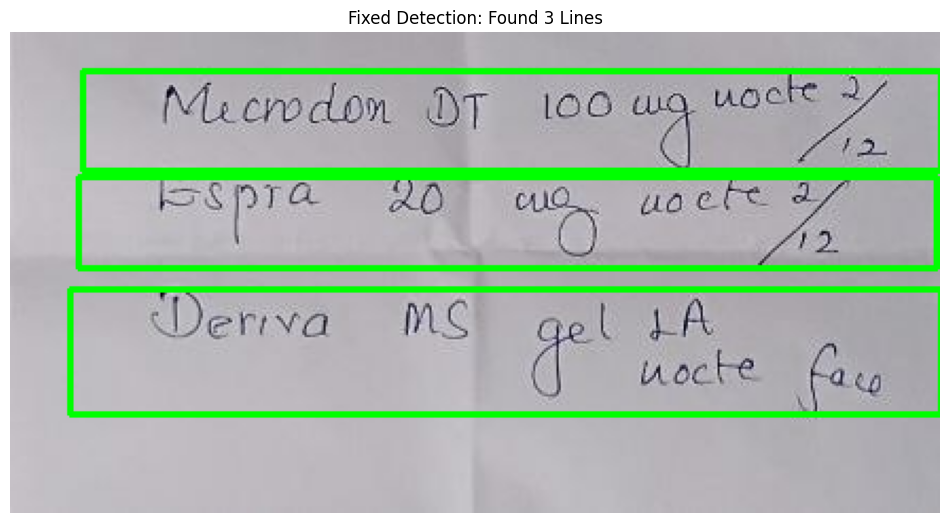

Successfully saved: ['line_0.jpg', 'line_2.jpg', 'line_3.jpg']


In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_lines_fixed(image_path):
    # 1. Read the image
    image = cv2.imread(image_path)
    if image is None:
        return "Error: Image not found"
        
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. Binary Thresholding
    # Keep using Otsu's method as it works well for ink on paper
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # --- THE FIX IS HERE ---
    # Previous: (50, 5) -> Too tall, merged lines.
    # New: (80, 1) -> Wider to connect words horizontally, but thinner (Height=1) to separate lines vertically.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 1)) 
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # 3. Find Contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 4. Filter and Sort
    line_images = []
    
    # Sort contours from top to bottom
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    (contours, bounding_boxes) = zip(*sorted(zip(contours, bounding_boxes), key=lambda b: b[1][1]))

    print(f"Detected {len(contours)} potential lines.")

    original_copy = image.copy()
    
    for i, box in enumerate(bounding_boxes):
        x, y, w, h = box
        
        # Filter: Only accept boxes that look like text lines (Width > 30, Height > 10)
        if w > 30 and h > 10: 
            # Crop logic
            y_start = max(0, y - 5)
            y_end = min(image.shape[0], y + h + 5)
            x_start = max(0, x - 5)
            x_end = min(image.shape[1], x + w + 5)
            
            cropped_line = image[y_start:y_end, x_start:x_end]
            
            # Save separately
            line_filename = f"line_{i}.jpg"
            cv2.imwrite(line_filename, cropped_line)
            line_images.append(line_filename)
            
            # Draw green box
            cv2.rectangle(original_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the result
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(original_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"Fixed Detection: Found {len(line_images)} Lines")
    plt.axis('off')
    plt.show()

    return line_images

# --- EXECUTION ---
detected_lines = segment_lines_fixed('test.jpg')
print(f"Successfully saved: {detected_lines}")

In [66]:
import os

# List of the segmented line images we created earlier
image_files = ['line_0.jpg', 'line_1.jpg', 'line_2.jpg']

print(f"Testing all {len(image_files)} lines at once...\n")
print(f"{'Line Image':<15} | {'Final Drug Match':<30} | {'Confidence'}")
print("-" * 65)

for img_path in image_files:
    if os.path.exists(img_path):
        # Run the production logic function on each image
        # (This uses the 'process_prescription_production' function we defined earlier)
        results = process_prescription_production(img_path)
        
        # Check if we got results and print the best match
        if results and len(results) > 0:
            best_match = results[0] # The first result is the highest scoring one
            print(f"{img_path:<15} | {best_match['drug']:<30} | {best_match['score']}%")
        else:
            print(f"{img_path:<15} | {'No Match Found':<30} | 0%")
    else:
        print(f"{img_path:<15} | FILE NOT FOUND (Please run segmentation code first)")

print("-" * 65)

Testing all 3 lines at once...

Line Image      | Final Drug Match               | Confidence
-----------------------------------------------------------------
AI Raw Prediction: </s>Macradon Dr. 100 mg waste #</s>
Final Smart Query: Macradon waste
line_0.jpg      | dornase alfa                   | 61.54%
line_1.jpg      | FILE NOT FOUND (Please run segmentation code first)
AI Raw Prediction: </s>Espra 20 megadote of</s>
Final Smart Query: Espra megadote
line_2.jpg      | Topiramate                     | 58.33%
-----------------------------------------------------------------


In [67]:
import pandas as pd

# 1. Load the existing CSV
csv_file = 'drug_database.csv'
df = pd.read_csv(csv_file)

# 2. Define the missing local drug brands
new_entries = [
    {'PROPRIETARYNAME': 'Espra', 'NONPROPRIETARYNAME': 'Esomeprazole'},
    {'PROPRIETARYNAME': 'Deriva MS', 'NONPROPRIETARYNAME': 'Adapalene'},
    {'PROPRIETARYNAME': 'Microdon DT', 'NONPROPRIETARYNAME': 'Domperidone'} 
]

# 3. Add to the dataframe
new_df = pd.DataFrame(new_entries)
updated_df = pd.concat([df, new_df], ignore_index=True)

# 4. Save back to CSV
updated_df.to_csv(csv_file, index=False)

# 5. Refresh the list in memory immediately
drug_list = pd.concat([updated_df['PROPRIETARYNAME'], updated_df['NONPROPRIETARYNAME']]).unique().tolist()

print(f"Success! Added {len(new_entries)} new drugs. Database now has {len(drug_list)} entries.")

Success! Added 3 new drugs. Database now has 53235 entries.


In [68]:
import cv2
import os

# --- PART A: Re-run Segmentation (To ensure line_1.jpg exists) ---
print("Re-generating line images...")
# Ensure you use the correct filename for your full image
full_image = 'test.jpg' 
image = cv2.imread(full_image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 1))
dilated = cv2.dilate(thresh, kernel, iterations=1)
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(c) for c in contours]
(contours, bounding_boxes) = zip(*sorted(zip(contours, bounding_boxes), key=lambda b: b[1][1]))

saved_files = []
for i, box in enumerate(bounding_boxes):
    x, y, w, h = box
    if w > 30 and h > 10:
        crop = image[max(0, y-5):min(image.shape[0], y+h+5), max(0, x-5):min(image.shape[1], x+w+5)]
        filename = f"line_{i}.jpg"
        cv2.imwrite(filename, crop)
        saved_files.append(filename)

# --- PART B: Test Matching with New Database ---
print(f"\nTesting {len(saved_files)} detected lines with updated Database...\n")
print(f"{'Image':<10} | {'OCR Text':<25} | {'MATCHED DRUG':<20} | {'Score'}")
print("-" * 75)

for img_path in saved_files:
    # Use the production logic function we wrote earlier
    results = process_prescription_production(img_path)
    
    if results:
        top_match = results[0]
        # We assume the function prints raw text, but let's just show the final result here
        print(f"{img_path:<10} | {'(See logs above)':<25} | {top_match['drug']:<20} | {top_match['score']}%")
    else:
        print(f"{img_path:<10} | {'No text detected'} | {'---'} | 0%")
print("-" * 75)

Re-generating line images...

Testing 3 detected lines with updated Database...

Image      | OCR Text                  | MATCHED DRUG         | Score
---------------------------------------------------------------------------
AI Raw Prediction: </s>Macradon Dr. 100 mg waste #</s>
Final Smart Query: Macradon waste
line_0.jpg | (See logs above)          | dornase alfa         | 61.54%
AI Raw Prediction: </s>Espra 20 megadote of</s>
Final Smart Query: Espra megadote
line_2.jpg | (See logs above)          | Espra                | 100.0%
AI Raw Prediction: </s>Deriva MS get taste face .</s>
Final Smart Query: Deriva get taste face
line_3.jpg | (See logs above)          | Deriva MS            | 80.0%
---------------------------------------------------------------------------


In [69]:
import pandas as pd

# Comprehensive Drug List for South Asia (Sri Lanka, India, Pakistan)
# Includes popular brands and SPC generic names
drug_data = [
    # --- ANTIBIOTICS (Penicillins & Cephalosporins) ---
    {"PROPRIETARYNAME": "Amoxil", "NONPROPRIETARYNAME": "Amoxicillin"},
    {"PROPRIETARYNAME": "Novamox", "NONPROPRIETARYNAME": "Amoxicillin"},
    {"PROPRIETARYNAME": "Augmentin", "NONPROPRIETARYNAME": "Co-amoxiclav"},
    {"PROPRIETARYNAME": "Clavam", "NONPROPRIETARYNAME": "Co-amoxiclav"},
    {"PROPRIETARYNAME": "Moxclav", "NONPROPRIETARYNAME": "Co-amoxiclav"},
    {"PROPRIETARYNAME": "Megapen", "NONPROPRIETARYNAME": "Ampicillin Cloxacillin"},
    {"PROPRIETARYNAME": "Ampiclox", "NONPROPRIETARYNAME": "Ampicillin Cloxacillin"},
    {"PROPRIETARYNAME": "Cloxacillin", "NONPROPRIETARYNAME": "Cloxacillin"},
    {"PROPRIETARYNAME": "Ospin", "NONPROPRIETARYNAME": "Phenoxymethylpenicillin"},
    {"PROPRIETARYNAME": "Penicillin V", "NONPROPRIETARYNAME": "Phenoxymethylpenicillin"},
    {"PROPRIETARYNAME": "Zinnat", "NONPROPRIETARYNAME": "Cefuroxime"},
    {"PROPRIETARYNAME": "Cefu", "NONPROPRIETARYNAME": "Cefuroxime"},
    {"PROPRIETARYNAME": "Ceftum", "NONPROPRIETARYNAME": "Cefuroxime"},
    {"PROPRIETARYNAME": "Sporidex", "NONPROPRIETARYNAME": "Cephalexin"},
    {"PROPRIETARYNAME": "Cephadex", "NONPROPRIETARYNAME": "Cephalexin"},
    {"PROPRIETARYNAME": "Taxim", "NONPROPRIETARYNAME": "Cefotaxime"},
    {"PROPRIETARYNAME": "Omnicef", "NONPROPRIETARYNAME": "Cefdinir"},
    {"PROPRIETARYNAME": "Suprax", "NONPROPRIETARYNAME": "Cefixime"},
    {"PROPRIETARYNAME": "Zifi", "NONPROPRIETARYNAME": "Cefixime"},
    {"PROPRIETARYNAME": "Rocephin", "NONPROPRIETARYNAME": "Ceftriaxone"},
    {"PROPRIETARYNAME": "Oframax", "NONPROPRIETARYNAME": "Ceftriaxone"},

    # --- ANTIBIOTICS (Macrolides, Fluoroquinolones, Others) ---
    {"PROPRIETARYNAME": "Azithral", "NONPROPRIETARYNAME": "Azithromycin"},
    {"PROPRIETARYNAME": "Zithromax", "NONPROPRIETARYNAME": "Azithromycin"},
    {"PROPRIETARYNAME": "Azee", "NONPROPRIETARYNAME": "Azithromycin"},
    {"PROPRIETARYNAME": "Klacid", "NONPROPRIETARYNAME": "Clarithromycin"},
    {"PROPRIETARYNAME": "Claribid", "NONPROPRIETARYNAME": "Clarithromycin"},
    {"PROPRIETARYNAME": "Erythrocin", "NONPROPRIETARYNAME": "Erythromycin"},
    {"PROPRIETARYNAME": "Cipro", "NONPROPRIETARYNAME": "Ciprofloxacin"},
    {"PROPRIETARYNAME": "Ciplox", "NONPROPRIETARYNAME": "Ciprofloxacin"},
    {"PROPRIETARYNAME": "Cifran", "NONPROPRIETARYNAME": "Ciprofloxacin"},
    {"PROPRIETARYNAME": "Levoflox", "NONPROPRIETARYNAME": "Levofloxacin"},
    {"PROPRIETARYNAME": "Tavanic", "NONPROPRIETARYNAME": "Levofloxacin"},
    {"PROPRIETARYNAME": "Levaquin", "NONPROPRIETARYNAME": "Levofloxacin"},
    {"PROPRIETARYNAME": "Norflox", "NONPROPRIETARYNAME": "Norfloxacin"},
    {"PROPRIETARYNAME": "Flagyl", "NONPROPRIETARYNAME": "Metronidazole"},
    {"PROPRIETARYNAME": "Metrogyl", "NONPROPRIETARYNAME": "Metronidazole"},
    {"PROPRIETARYNAME": "Fasigyn", "NONPROPRIETARYNAME": "Tinidazole"},
    {"PROPRIETARYNAME": "Doxy", "NONPROPRIETARYNAME": "Doxycycline"},
    {"PROPRIETARYNAME": "Vibramycin", "NONPROPRIETARYNAME": "Doxycycline"},
    {"PROPRIETARYNAME": "Dalacin", "NONPROPRIETARYNAME": "Clindamycin"},
    {"PROPRIETARYNAME": "Vancocin", "NONPROPRIETARYNAME": "Vancomycin"},
    {"PROPRIETARYNAME": "Septrin", "NONPROPRIETARYNAME": "Co-trimoxazole"},
    {"PROPRIETARYNAME": "Bactrim", "NONPROPRIETARYNAME": "Co-trimoxazole"},

    # --- PAIN, INFLAMMATION & FEVER (NSAIDs/Analgesics) ---
    {"PROPRIETARYNAME": "Panadol", "NONPROPRIETARYNAME": "Paracetamol"},
    {"PROPRIETARYNAME": "Calpol", "NONPROPRIETARYNAME": "Paracetamol"},
    {"PROPRIETARYNAME": "Dolo", "NONPROPRIETARYNAME": "Paracetamol"},
    {"PROPRIETARYNAME": "Brufen", "NONPROPRIETARYNAME": "Ibuprofen"},
    {"PROPRIETARYNAME": "Advil", "NONPROPRIETARYNAME": "Ibuprofen"},
    {"PROPRIETARYNAME": "Ibuflam", "NONPROPRIETARYNAME": "Ibuprofen"},
    {"PROPRIETARYNAME": "Voltaren", "NONPROPRIETARYNAME": "Diclofenac Sodium"},
    {"PROPRIETARYNAME": "Voren", "NONPROPRIETARYNAME": "Diclofenac Sodium"},
    {"PROPRIETARYNAME": "Diclofenac", "NONPROPRIETARYNAME": "Diclofenac Sodium"},
    {"PROPRIETARYNAME": "Cataflam", "NONPROPRIETARYNAME": "Diclofenac Potassium"},
    {"PROPRIETARYNAME": "Ponstan", "NONPROPRIETARYNAME": "Mefenamic Acid"},
    {"PROPRIETARYNAME": "Meftal", "NONPROPRIETARYNAME": "Mefenamic Acid"},
    {"PROPRIETARYNAME": "Celebrex", "NONPROPRIETARYNAME": "Celecoxib"},
    {"PROPRIETARYNAME": "Arcoxia", "NONPROPRIETARYNAME": "Etoricoxib"},
    {"PROPRIETARYNAME": "Indocid", "NONPROPRIETARYNAME": "Indomethacin"},
    {"PROPRIETARYNAME": "Naprosyn", "NONPROPRIETARYNAME": "Naproxen"},
    {"PROPRIETARYNAME": "Tramal", "NONPROPRIETARYNAME": "Tramadol"},
    {"PROPRIETARYNAME": "Ultracet", "NONPROPRIETARYNAME": "Tramadol Paracetamol"},
    {"PROPRIETARYNAME": "Zyloric", "NONPROPRIETARYNAME": "Allopurinol"},
    {"PROPRIETARYNAME": "Colgout", "NONPROPRIETARYNAME": "Colchicine"},

    # --- DIABETES (Anti-Diabetic) ---
    {"PROPRIETARYNAME": "Glucophage", "NONPROPRIETARYNAME": "Metformin"},
    {"PROPRIETARYNAME": "Glycomet", "NONPROPRIETARYNAME": "Metformin"},
    {"PROPRIETARYNAME": "Metformin", "NONPROPRIETARYNAME": "Metformin"},
    {"PROPRIETARYNAME": "Daonil", "NONPROPRIETARYNAME": "Glibenclamide"},
    {"PROPRIETARYNAME": "Diamicron", "NONPROPRIETARYNAME": "Gliclazide"},
    {"PROPRIETARYNAME": "Reclide", "NONPROPRIETARYNAME": "Gliclazide"},
    {"PROPRIETARYNAME": "Amaryl", "NONPROPRIETARYNAME": "Glimepiride"},
    {"PROPRIETARYNAME": "Januvia", "NONPROPRIETARYNAME": "Sitagliptin"},
    {"PROPRIETARYNAME": "Istavel", "NONPROPRIETARYNAME": "Sitagliptin"},
    {"PROPRIETARYNAME": "Galvus", "NONPROPRIETARYNAME": "Vildagliptin"},
    {"PROPRIETARYNAME": "Trajenta", "NONPROPRIETARYNAME": "Linagliptin"},
    {"PROPRIETARYNAME": "Jardiance", "NONPROPRIETARYNAME": "Empagliflozin"},
    {"PROPRIETARYNAME": "Forxiga", "NONPROPRIETARYNAME": "Dapagliflozin"},
    {"PROPRIETARYNAME": "Actos", "NONPROPRIETARYNAME": "Pioglitazone"},
    {"PROPRIETARYNAME": "Mixtard", "NONPROPRIETARYNAME": "Insulin Isophane"},
    {"PROPRIETARYNAME": "Lantus", "NONPROPRIETARYNAME": "Insulin Glargine"},
    {"PROPRIETARYNAME": "Actrapid", "NONPROPRIETARYNAME": "Insulin Soluble"},

    # --- CARDIAC & BLOOD PRESSURE ---
    {"PROPRIETARYNAME": "Losar", "NONPROPRIETARYNAME": "Losartan"},
    {"PROPRIETARYNAME": "Cozaar", "NONPROPRIETARYNAME": "Losartan"},
    {"PROPRIETARYNAME": "Losartan", "NONPROPRIETARYNAME": "Losartan"},
    {"PROPRIETARYNAME": "Telma", "NONPROPRIETARYNAME": "Telmisartan"},
    {"PROPRIETARYNAME": "Micardis", "NONPROPRIETARYNAME": "Telmisartan"},
    {"PROPRIETARYNAME": "Diovan", "NONPROPRIETARYNAME": "Valsartan"},
    {"PROPRIETARYNAME": "Atacand", "NONPROPRIETARYNAME": "Candesartan"},
    {"PROPRIETARYNAME": "Envas", "NONPROPRIETARYNAME": "Enalapril"},
    {"PROPRIETARYNAME": "Renitec", "NONPROPRIETARYNAME": "Enalapril"},
    {"PROPRIETARYNAME": "Zestril", "NONPROPRIETARYNAME": "Lisinopril"},
    {"PROPRIETARYNAME": "Ramipril", "NONPROPRIETARYNAME": "Ramipril"},
    {"PROPRIETARYNAME": "Norvasc", "NONPROPRIETARYNAME": "Amlodipine"},
    {"PROPRIETARYNAME": "Amlogard", "NONPROPRIETARYNAME": "Amlodipine"},
    {"PROPRIETARYNAME": "Stamlo", "NONPROPRIETARYNAME": "Amlodipine"},
    {"PROPRIETARYNAME": "Nifedi", "NONPROPRIETARYNAME": "Nifedipine"},
    {"PROPRIETARYNAME": "Adalat", "NONPROPRIETARYNAME": "Nifedipine"},
    {"PROPRIETARYNAME": "Herbesser", "NONPROPRIETARYNAME": "Diltiazem"},
    {"PROPRIETARYNAME": "Isoptin", "NONPROPRIETARYNAME": "Verapamil"},
    {"PROPRIETARYNAME": "Tenormin", "NONPROPRIETARYNAME": "Atenolol"},
    {"PROPRIETARYNAME": "Atenolol", "NONPROPRIETARYNAME": "Atenolol"},
    {"PROPRIETARYNAME": "Betaloc", "NONPROPRIETARYNAME": "Metoprolol"},
    {"PROPRIETARYNAME": "Concor", "NONPROPRIETARYNAME": "Bisoprolol"},
    {"PROPRIETARYNAME": "Carvedilol", "NONPROPRIETARYNAME": "Carvedilol"},
    {"PROPRIETARYNAME": "Inderal", "NONPROPRIETARYNAME": "Propranolol"},
    {"PROPRIETARYNAME": "Lasix", "NONPROPRIETARYNAME": "Furosemide"},
    {"PROPRIETARYNAME": "Aldactone", "NONPROPRIETARYNAME": "Spironolactone"},
    {"PROPRIETARYNAME": "Natrilix", "NONPROPRIETARYNAME": "Indapamide"},
    {"PROPRIETARYNAME": "Lipitor", "NONPROPRIETARYNAME": "Atorvastatin"},
    {"PROPRIETARYNAME": "Atorva", "NONPROPRIETARYNAME": "Atorvastatin"},
    {"PROPRIETARYNAME": "Crestor", "NONPROPRIETARYNAME": "Rosuvastatin"},
    {"PROPRIETARYNAME": "Rosuvas", "NONPROPRIETARYNAME": "Rosuvastatin"},
    {"PROPRIETARYNAME": "Zocor", "NONPROPRIETARYNAME": "Simvastatin"},
    {"PROPRIETARYNAME": "Ecosprin", "NONPROPRIETARYNAME": "Aspirin"},
    {"PROPRIETARYNAME": "Aspirin", "NONPROPRIETARYNAME": "Acetylsalicylic Acid"},
    {"PROPRIETARYNAME": "Plavix", "NONPROPRIETARYNAME": "Clopidogrel"},
    {"PROPRIETARYNAME": "Clopilet", "NONPROPRIETARYNAME": "Clopidogrel"},
    {"PROPRIETARYNAME": "Brilinta", "NONPROPRIETARYNAME": "Ticagrelor"},
    {"PROPRIETARYNAME": "Angisid", "NONPROPRIETARYNAME": "Glyceryl Trinitrate"},
    {"PROPRIETARYNAME": "Imdur", "NONPROPRIETARYNAME": "Isosorbide Mononitrate"},

    # --- GASTRITIS & ACID REFLUX ---
    {"PROPRIETARYNAME": "Omez", "NONPROPRIETARYNAME": "Omeprazole"},
    {"PROPRIETARYNAME": "Omeprazole", "NONPROPRIETARYNAME": "Omeprazole"},
    {"PROPRIETARYNAME": "Nexium", "NONPROPRIETARYNAME": "Esomeprazole"},
    {"PROPRIETARYNAME": "Espra", "NONPROPRIETARYNAME": "Esomeprazole"},
    {"PROPRIETARYNAME": "Pantocid", "NONPROPRIETARYNAME": "Pantoprazole"},
    {"PROPRIETARYNAME": "Pantop", "NONPROPRIETARYNAME": "Pantoprazole"},
    {"PROPRIETARYNAME": "Pariet", "NONPROPRIETARYNAME": "Rabeprazole"},
    {"PROPRIETARYNAME": "Lanzol", "NONPROPRIETARYNAME": "Lansoprazole"},
    {"PROPRIETARYNAME": "Famotidine", "NONPROPRIETARYNAME": "Famotidine"},
    {"PROPRIETARYNAME": "Zantac", "NONPROPRIETARYNAME": "Ranitidine"},
    {"PROPRIETARYNAME": "Gaviscon", "NONPROPRIETARYNAME": "Alginic Acid"},
    {"PROPRIETARYNAME": "Digene", "NONPROPRIETARYNAME": "Antacid"},
    {"PROPRIETARYNAME": "Gelusil", "NONPROPRIETARYNAME": "Antacid"},
    {"PROPRIETARYNAME": "Motilium", "NONPROPRIETARYNAME": "Domperidone"},
    {"PROPRIETARYNAME": "Microdon DT", "NONPROPRIETARYNAME": "Domperidone"},
    {"PROPRIETARYNAME": "Vometa", "NONPROPRIETARYNAME": "Domperidone"},
    {"PROPRIETARYNAME": "Ganaton", "NONPROPRIETARYNAME": "Itopride"},
    {"PROPRIETARYNAME": "Buscopan", "NONPROPRIETARYNAME": "Hyoscine Butylbromide"},
    {"PROPRIETARYNAME": "Duspatalin", "NONPROPRIETARYNAME": "Mebeverine"},
    {"PROPRIETARYNAME": "Imodium", "NONPROPRIETARYNAME": "Loperamide"},
    {"PROPRIETARYNAME": "Dulcolax", "NONPROPRIETARYNAME": "Bisacodyl"},
    {"PROPRIETARYNAME": "Duphalac", "NONPROPRIETARYNAME": "Lactulose"},
    {"PROPRIETARYNAME": "Emeset", "NONPROPRIETARYNAME": "Ondansetron"},
    {"PROPRIETARYNAME": "Zofran", "NONPROPRIETARYNAME": "Ondansetron"},
    {"PROPRIETARYNAME": "Stemetil", "NONPROPRIETARYNAME": "Prochlorperazine"},
    {"PROPRIETARYNAME": "Avomine", "NONPROPRIETARYNAME": "Promethazine"},

    # --- RESPIRATORY & ALLERGY ---
    {"PROPRIETARYNAME": "Piriton", "NONPROPRIETARYNAME": "Chlorphenamine"},
    {"PROPRIETARYNAME": "Avil", "NONPROPRIETARYNAME": "Pheniramine"},
    {"PROPRIETARYNAME": "Cetzine", "NONPROPRIETARYNAME": "Cetirizine"},
    {"PROPRIETARYNAME": "Zyrtec", "NONPROPRIETARYNAME": "Cetirizine"},
    {"PROPRIETARYNAME": "Cetirizine", "NONPROPRIETARYNAME": "Cetirizine"},
    {"PROPRIETARYNAME": "Allegra", "NONPROPRIETARYNAME": "Fexofenadine"},
    {"PROPRIETARYNAME": "Fexet", "NONPROPRIETARYNAME": "Fexofenadine"},
    {"PROPRIETARYNAME": "Clarityne", "NONPROPRIETARYNAME": "Loratadine"},
    {"PROPRIETARYNAME": "Loratadine", "NONPROPRIETARYNAME": "Loratadine"},
    {"PROPRIETARYNAME": "Aerius", "NONPROPRIETARYNAME": "Desloratadine"},
    {"PROPRIETARYNAME": "Xyzal", "NONPROPRIETARYNAME": "Levocetirizine"},
    {"PROPRIETARYNAME": "Ventolin", "NONPROPRIETARYNAME": "Salbutamol"},
    {"PROPRIETARYNAME": "Asthalin", "NONPROPRIETARYNAME": "Salbutamol"},
    {"PROPRIETARYNAME": "Seretide", "NONPROPRIETARYNAME": "Salmeterol Fluticasone"},
    {"PROPRIETARYNAME": "Symbicort", "NONPROPRIETARYNAME": "Budesonide Formoterol"},
    {"PROPRIETARYNAME": "Deriphyllin", "NONPROPRIETARYNAME": "Etofylline Theophylline"},
    {"PROPRIETARYNAME": "Theophylline", "NONPROPRIETARYNAME": "Theophylline"},
    {"PROPRIETARYNAME": "Singulair", "NONPROPRIETARYNAME": "Montelukast"},
    {"PROPRIETARYNAME": "Montek", "NONPROPRIETARYNAME": "Montelukast"},
    {"PROPRIETARYNAME": "Ascoril", "NONPROPRIETARYNAME": "Expectorant"},
    {"PROPRIETARYNAME": "Benadryl", "NONPROPRIETARYNAME": "Diphenhydramine"},
    {"PROPRIETARYNAME": "Prednisolone", "NONPROPRIETARYNAME": "Prednisolone"},
    {"PROPRIETARYNAME": "Dexamethasone", "NONPROPRIETARYNAME": "Dexamethasone"},

    # --- CNS / PSYCHIATRY / NEUROLOGY ---
    {"PROPRIETARYNAME": "Valium", "NONPROPRIETARYNAME": "Diazepam"},
    {"PROPRIETARYNAME": "Ativan", "NONPROPRIETARYNAME": "Lorazepam"},
    {"PROPRIETARYNAME": "Xanax", "NONPROPRIETARYNAME": "Alprazolam"},
    {"PROPRIETARYNAME": "Alprax", "NONPROPRIETARYNAME": "Alprazolam"},
    {"PROPRIETARYNAME": "Rivotril", "NONPROPRIETARYNAME": "Clonazepam"},
    {"PROPRIETARYNAME": "Clonapax", "NONPROPRIETARYNAME": "Clonazepam"},
    {"PROPRIETARYNAME": "Frisium", "NONPROPRIETARYNAME": "Clobazam"},
    {"PROPRIETARYNAME": "Tegretol", "NONPROPRIETARYNAME": "Carbamazepine"},
    {"PROPRIETARYNAME": "Zeptol", "NONPROPRIETARYNAME": "Carbamazepine"},
    {"PROPRIETARYNAME": "Epilim", "NONPROPRIETARYNAME": "Sodium Valproate"},
    {"PROPRIETARYNAME": "Valparin", "NONPROPRIETARYNAME": "Sodium Valproate"},
    {"PROPRIETARYNAME": "Eptoin", "NONPROPRIETARYNAME": "Phenytoin"},
    {"PROPRIETARYNAME": "Dilantin", "NONPROPRIETARYNAME": "Phenytoin"},
    {"PROPRIETARYNAME": "Gardenal", "NONPROPRIETARYNAME": "Phenobarbital"},
    {"PROPRIETARYNAME": "Neurontin", "NONPROPRIETARYNAME": "Gabapentin"},
    {"PROPRIETARYNAME": "Lyrica", "NONPROPRIETARYNAME": "Pregabalin"},
    {"PROPRIETARYNAME": "Keppra", "NONPROPRIETARYNAME": "Levetiracetam"},
    {"PROPRIETARYNAME": "Lamictal", "NONPROPRIETARYNAME": "Lamotrigine"},
    {"PROPRIETARYNAME": "Topamax", "NONPROPRIETARYNAME": "Topiramate"},
    {"PROPRIETARYNAME": "Prozac", "NONPROPRIETARYNAME": "Fluoxetine"},
    {"PROPRIETARYNAME": "Flunil", "NONPROPRIETARYNAME": "Fluoxetine"},
    {"PROPRIETARYNAME": "Zoloft", "NONPROPRIETARYNAME": "Sertraline"},
    {"PROPRIETARYNAME": "Daxid", "NONPROPRIETARYNAME": "Sertraline"},
    {"PROPRIETARYNAME": "Cipramil", "NONPROPRIETARYNAME": "Citalopram"},
    {"PROPRIETARYNAME": "Nexito", "NONPROPRIETARYNAME": "Escitalopram"},
    {"PROPRIETARYNAME": "Seroxat", "NONPROPRIETARYNAME": "Paroxetine"},
    {"PROPRIETARYNAME": "Efexor", "NONPROPRIETARYNAME": "Venlafaxine"},
    {"PROPRIETARYNAME": "Cymbalta", "NONPROPRIETARYNAME": "Duloxetine"},
    {"PROPRIETARYNAME": "Elavil", "NONPROPRIETARYNAME": "Amitriptyline"},
    {"PROPRIETARYNAME": "Risperdal", "NONPROPRIETARYNAME": "Risperidone"},
    {"PROPRIETARYNAME": "Zyprexa", "NONPROPRIETARYNAME": "Olanzapine"},
    {"PROPRIETARYNAME": "Seroquel", "NONPROPRIETARYNAME": "Quetiapine"},
    {"PROPRIETARYNAME": "Serenace", "NONPROPRIETARYNAME": "Haloperidol"},
    {"PROPRIETARYNAME": "Largactil", "NONPROPRIETARYNAME": "Chlorpromazine"},
    {"PROPRIETARYNAME": "Stugeron", "NONPROPRIETARYNAME": "Cinnarizine"},
    {"PROPRIETARYNAME": "Vertin", "NONPROPRIETARYNAME": "Betahistine"},

    # --- VITAMINS & MINERALS ---
    {"PROPRIETARYNAME": "Vitamin C", "NONPROPRIETARYNAME": "Ascorbic Acid"},
    {"PROPRIETARYNAME": "Celin", "NONPROPRIETARYNAME": "Ascorbic Acid"},
    {"PROPRIETARYNAME": "Neurobion", "NONPROPRIETARYNAME": "Vitamin B Complex"},
    {"PROPRIETARYNAME": "Becosules", "NONPROPRIETARYNAME": "Vitamin B Complex"},
    {"PROPRIETARYNAME": "Polybion", "NONPROPRIETARYNAME": "Vitamin B Complex"},
    {"PROPRIETARYNAME": "Folic Acid", "NONPROPRIETARYNAME": "Folic Acid"},
    {"PROPRIETARYNAME": "Folvite", "NONPROPRIETARYNAME": "Folic Acid"},
    {"PROPRIETARYNAME": "Fefol", "NONPROPRIETARYNAME": "Iron Folic Acid"},
    {"PROPRIETARYNAME": "Ferrous Sulphate", "NONPROPRIETARYNAME": "Iron"},
    {"PROPRIETARYNAME": "Calcium", "NONPROPRIETARYNAME": "Calcium Carbonate"},
    {"PROPRIETARYNAME": "Calci-D", "NONPROPRIETARYNAME": "Calcium Vitamin D"},
    {"PROPRIETARYNAME": "Shelcal", "NONPROPRIETARYNAME": "Calcium Vitamin D"},
    {"PROPRIETARYNAME": "Evion", "NONPROPRIETARYNAME": "Vitamin E"},
    {"PROPRIETARYNAME": "Seven Seas", "NONPROPRIETARYNAME": "Cod Liver Oil"},
    {"PROPRIETARYNAME": "Thiamine", "NONPROPRIETARYNAME": "Vitamin B1"},
    {"PROPRIETARYNAME": "Pyridoxine", "NONPROPRIETARYNAME": "Vitamin B6"},
    {"PROPRIETARYNAME": "Methycobal", "NONPROPRIETARYNAME": "Methylcobalamin"},

    # --- SKIN & DERMATOLOGY ---
    {"PROPRIETARYNAME": "Deriva MS", "NONPROPRIETARYNAME": "Adapalene"},
    {"PROPRIETARYNAME": "Adapen", "NONPROPRIETARYNAME": "Adapalene"},
    {"PROPRIETARYNAME": "Retino-A", "NONPROPRIETARYNAME": "Tretinoin"},
    {"PROPRIETARYNAME": "Betnovate", "NONPROPRIETARYNAME": "Betamethasone"},
    {"PROPRIETARYNAME": "Betnelan", "NONPROPRIETARYNAME": "Betamethasone"},
    {"PROPRIETARYNAME": "Dermovate", "NONPROPRIETARYNAME": "Clobetasol"},
    {"PROPRIETARYNAME": "Tenovate", "NONPROPRIETARYNAME": "Clobetasol"},
    {"PROPRIETARYNAME": "Candid", "NONPROPRIETARYNAME": "Clotrimazole"},
    {"PROPRIETARYNAME": "Canesten", "NONPROPRIETARYNAME": "Clotrimazole"},
    {"PROPRIETARYNAME": "Nizoral", "NONPROPRIETARYNAME": "Ketoconazole"},
    {"PROPRIETARYNAME": "Daktarin", "NONPROPRIETARYNAME": "Miconazole"},
    {"PROPRIETARYNAME": "Soframycin", "NONPROPRIETARYNAME": "Framycetin"},
    {"PROPRIETARYNAME": "Fucidin", "NONPROPRIETARYNAME": "Fusidic Acid"},
    {"PROPRIETARYNAME": "Bactroban", "NONPROPRIETARYNAME": "Mupirocin"},
    {"PROPRIETARYNAME": "T-Bact", "NONPROPRIETARYNAME": "Mupirocin"},
    {"PROPRIETARYNAME": "Acne-UV", "NONPROPRIETARYNAME": "Sunscreen"},
    {"PROPRIETARYNAME": "Permethrin", "NONPROPRIETARYNAME": "Permethrin"},
    {"PROPRIETARYNAME": "Scaboma", "NONPROPRIETARYNAME": "Permethrin"},
    {"PROPRIETARYNAME": "Calamine", "NONPROPRIETARYNAME": "Calamine Lotion"},
    {"PROPRIETARYNAME": "Silverex", "NONPROPRIETARYNAME": "Silver Sulfadiazine"},
    {"PROPRIETARYNAME": "Burnol", "NONPROPRIETARYNAME": "Aminacrine Cetrimide"},

    # --- OTHER ESSENTIALS ---
    {"PROPRIETARYNAME": "Eltroxin", "NONPROPRIETARYNAME": "Thyroxine"},
    {"PROPRIETARYNAME": "Thyronorm", "NONPROPRIETARYNAME": "Thyroxine"},
    {"PROPRIETARYNAME": "Neo-Mercazole", "NONPROPRIETARYNAME": "Carbimazole"},
    {"PROPRIETARYNAME": "Viagra", "NONPROPRIETARYNAME": "Sildenafil"},
    {"PROPRIETARYNAME": "Silagra", "NONPROPRIETARYNAME": "Sildenafil"},
    {"PROPRIETARYNAME": "Cialis", "NONPROPRIETARYNAME": "Tadalafil"},
    {"PROPRIETARYNAME": "Wormin", "NONPROPRIETARYNAME": "Mebendazole"},
    {"PROPRIETARYNAME": "Vermox", "NONPROPRIETARYNAME": "Mebendazole"},
    {"PROPRIETARYNAME": "Zentel", "NONPROPRIETARYNAME": "Albendazole"},
    {"PROPRIETARYNAME": "Alben", "NONPROPRIETARYNAME": "Albendazole"},
    {"PROPRIETARYNAME": "Banocide", "NONPROPRIETARYNAME": "Diethylcarbamazine"},
    {"PROPRIETARYNAME": "Ivermectin", "NONPROPRIETARYNAME": "Ivermectin"},
    {"PROPRIETARYNAME": "Tamoxifen", "NONPROPRIETARYNAME": "Tamoxifen"},
    {"PROPRIETARYNAME": "Letrozole", "NONPROPRIETARYNAME": "Letrozole"},
    {"PROPRIETARYNAME": "Methotrexate", "NONPROPRIETARYNAME": "Methotrexate"},
    {"PROPRIETARYNAME": "Siddhalepa", "NONPROPRIETARYNAME": "Ayurvedic Balm"},
    {"PROPRIETARYNAME": "Samahan", "NONPROPRIETARYNAME": "Ayurvedic Granules"},
    {"PROPRIETARYNAME": "Jeewani", "NONPROPRIETARYNAME": "Oral Rehydration Salts"},
    {"PROPRIETARYNAME": "Depo-Provera", "NONPROPRIETARYNAME": "Medroxyprogesterone"},
    {"PROPRIETARYNAME": "Mithuri", "NONPROPRIETARYNAME": "Oral Contraceptive"},
    {"PROPRIETARYNAME": "Postinor", "NONPROPRIETARYNAME": "Levonorgestrel"}
]

# Create DataFrame
df = pd.DataFrame(drug_data)

# Save to CSV (Overwriting the old one)
csv_filename = 'drug_database.csv'
df.to_csv(csv_filename, index=False)

print(f"Success! Created new Sri Lankan Drug Database with {len(df)} entries.")
print("Sample entries:")
print(df.head())

Success! Created new Sri Lankan Drug Database with 263 entries.
Sample entries:
  PROPRIETARYNAME NONPROPRIETARYNAME
0          Amoxil        Amoxicillin
1         Novamox        Amoxicillin
2       Augmentin       Co-amoxiclav
3          Clavam       Co-amoxiclav
4         Moxclav       Co-amoxiclav


In [1]:
import requests
import pandas as pd

def download_global_drugs(limit=1000):
    """
    Connects to the openFDA API and downloads brand and generic names.
    This is free and covers global drug data.
    """
    print(f"Connecting to global database to fetch {limit} records...")
    
    # URL for openFDA API (Drug label endpoint)
    url = f"https://api.fda.gov/drug/label.json?limit={limit}"
    
    try:
        response = requests.get(url)
        # Check if the connection is successful (Status code 200)
        if response.status_code == 200:
            data = response.json()
            results = []
            
            # Loop through the results to extract names
            for item in data.get('results', []):
                # openFDA provides data inside the 'openfda' field
                open_data = item.get('openfda', {})
                
                brand = open_data.get('brand_name', [None])[0]
                generic = open_data.get('generic_name', [None])[0]
                
                if brand and generic:
                    results.append({
                        "PROPRIETARYNAME": brand.upper(), 
                        "NONPROPRIETARYNAME": generic.upper()
                    })
            
            # Create a DataFrame and save to CSV
            df = pd.DataFrame(results)
            df.to_csv("massive_drug_list.csv", index=False)
            
            print(f"Success! Downloaded {len(df)} unique drug records.")
            print("File saved as: massive_drug_list.csv")
            return df
        else:
            print(f"Error: Could not connect. Status Code: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- HOW TO RUN ---
# Run the function below to start the download
# drug_df = download_global_drugs(1000)

In [2]:
download_global_drugs(1000)

Connecting to global database to fetch 1000 records...
Success! Downloaded 406 unique drug records.
File saved as: massive_drug_list.csv


,PROPRIETARYNAME,NONPROPRIETARYNAME
0,SILICEA,SILICEA
1,BETADINE,POVIDONE-IODINE
2,NAPROXEN,NAPROXEN
3,MOISTURIZING ANTIBACTERIAL,BENZALKONIUM CHLORIDE
4,QUICK ACTION,SALICYLIC ACID
...,...,...
401,EMVITA 23,"AGARICUS MUSCARIUS, CUPRUM MET, HYPOPHYSIS, RH..."
402,EQUATE OLOPATADINE HYDROCHLORIDE OPHTHALMIC SO...,OLOPATADINE HYDROCHLORIDE OPHTHALMIC SOLUTION
403,SOLIFENACIN SUCCINATE,SOLIFENACIN SUCCINATE
404,EXTRA STRENGTH ACETAMINOPHEN PM,ACETAMINOPHEN 500MG/ DIPHENHYDRAMINE HCL 25MG


In [3]:
import requests
import pandas as pd
import time

def download_massive_dataset(target_count=10000):
    """
    Downloads a large dataset by looping through the API (Pagination).
    target_count: How many records you want (e.g., 10,000 or 50,000).
    """
    print(f"Starting massive download... Target: {target_count} records.")
    
    all_results = []
    skip = 0
    batch_size = 1000  # API limit per request
    
    while skip < target_count:
        # Construct URL with 'skip' to get the next batch
        url = f"https://api.fda.gov/drug/label.json?limit={batch_size}&skip={skip}"
        
        try:
            print(f"Fetching batch: {skip} to {skip + batch_size}...")
            response = requests.get(url)
            
            if response.status_code == 200:
                data = response.json()
                items = data.get('results', [])
                
                if not items:
                    print("No more data available from API.")
                    break
                
                # Extract names
                for item in items:
                    open_data = item.get('openfda', {})
                    brand = open_data.get('brand_name', [None])[0]
                    generic = open_data.get('generic_name', [None])[0]
                    
                    # Only keep if both names exist
                    if brand and generic:
                        all_results.append({
                            "PROPRIETARYNAME": brand.upper(), 
                            "NONPROPRIETARYNAME": generic.upper()
                        })
                
                skip += batch_size
                # Sleep for 1 second to respect API limits (Politeness)
                time.sleep(1)
                
            else:
                print(f"API Error at skip {skip}: {response.status_code}")
                break
                
        except Exception as e:
            print(f"Connection Error: {e}")
            break

    # Save everything to one big CSV
    if all_results:
        # Remove duplicates
        df = pd.DataFrame(all_results).drop_duplicates()
        filename = "massive_drug_list.csv"
        df.to_csv(filename, index=False)
        
        print("-" * 40)
        print(f"✅ MISSION COMPLETE!")
        print(f"Total Unique Drugs Saved: {len(df)}")
        print(f"Saved to: {filename}")
        print("-" * 40)
        return df
    else:
        print("No data downloaded.")
        return None

# --- RUN THIS TO DOWNLOAD 10,000 RECORDS ---
# You can change 10000 to 50000 if you want more (it will take longer)
df = download_massive_dataset(10000)

Starting massive download... Target: 10000 records.
Fetching batch: 0 to 1000...
Fetching batch: 1000 to 2000...
Fetching batch: 2000 to 3000...
Fetching batch: 3000 to 4000...
Fetching batch: 4000 to 5000...
Fetching batch: 5000 to 6000...
Fetching batch: 6000 to 7000...
Fetching batch: 7000 to 8000...
Fetching batch: 8000 to 9000...
Fetching batch: 9000 to 10000...
----------------------------------------
✅ MISSION COMPLETE!
Total Unique Drugs Saved: 2896
Saved to: massive_drug_list.csv
----------------------------------------


In [4]:
import requests
import pandas as pd
import time

def download_massive_dataset(target_count=10000):
    """
    Downloads a large dataset by looping through the API (Pagination).
    target_count: How many records you want (e.g., 10,000 or 50,000).
    """
    print(f"Starting massive download... Target: {target_count} records.")
    
    all_results = []
    skip = 0
    batch_size = 1000  # API limit per request
    
    while skip < target_count:
        # Construct URL with 'skip' to get the next batch
        url = f"https://api.fda.gov/drug/label.json?limit={batch_size}&skip={skip}"
        
        try:
            print(f"Fetching batch: {skip} to {skip + batch_size}...")
            response = requests.get(url)
            
            if response.status_code == 200:
                data = response.json()
                items = data.get('results', [])
                
                if not items:
                    print("No more data available from API.")
                    break
                
                # Extract names
                for item in items:
                    open_data = item.get('openfda', {})
                    brand = open_data.get('brand_name', [None])[0]
                    generic = open_data.get('generic_name', [None])[0]
                    
                    # Only keep if both names exist
                    if brand and generic:
                        all_results.append({
                            "PROPRIETARYNAME": brand.upper(), 
                            "NONPROPRIETARYNAME": generic.upper()
                        })
                
                skip += batch_size
                # Sleep for 1 second to respect API limits (Politeness)
                time.sleep(1)
                
            else:
                print(f"API Error at skip {skip}: {response.status_code}")
                break
                
        except Exception as e:
            print(f"Connection Error: {e}")
            break

    # Save everything to one big CSV
    if all_results:
        # Remove duplicates
        df = pd.DataFrame(all_results).drop_duplicates()
        filename = "massive_drug_list.csv"
        df.to_csv(filename, index=False)
        
        print("-" * 40)
        print(f"✅ MISSION COMPLETE!")
        print(f"Total Unique Drugs Saved: {len(df)}")
        print(f"Saved to: {filename}")
        print("-" * 40)
        return df
    else:
        print("No data downloaded.")
        return None

# --- RUN THIS TO DOWNLOAD 10,000 RECORDS ---
# You can change 10000 to 50000 if you want more (it will take longer)
df = download_massive_dataset(50000)

Starting massive download... Target: 50000 records.
Fetching batch: 0 to 1000...
Fetching batch: 1000 to 2000...
Fetching batch: 2000 to 3000...
Fetching batch: 3000 to 4000...
Fetching batch: 4000 to 5000...
Fetching batch: 5000 to 6000...
Fetching batch: 6000 to 7000...
Fetching batch: 7000 to 8000...
Fetching batch: 8000 to 9000...
Fetching batch: 9000 to 10000...
Fetching batch: 10000 to 11000...
Fetching batch: 11000 to 12000...
Fetching batch: 12000 to 13000...
Fetching batch: 13000 to 14000...
Fetching batch: 14000 to 15000...
Fetching batch: 15000 to 16000...
Fetching batch: 16000 to 17000...
Fetching batch: 17000 to 18000...
Fetching batch: 18000 to 19000...
Fetching batch: 19000 to 20000...
Fetching batch: 20000 to 21000...
Fetching batch: 21000 to 22000...
Fetching batch: 22000 to 23000...
Fetching batch: 23000 to 24000...
Fetching batch: 24000 to 25000...
Fetching batch: 25000 to 26000...
Fetching batch: 26000 to 27000...
API Error at skip 26000: 400
-----------------------

In [ ]:
import pandas as pd
import os

def merge_specific_files():
    print("Loading datasets...")
    
   
    try:
        if os.path.exists("massive_drug_list.csv"):
            api_df = pd.read_csv("massive_drug_list.csv")
            print(f"API Data Loaded: {len(api_df)} records")
        else:
            api_df = pd.DataFrame(columns=["PROPRIETARYNAME", "NONPROPRIETARYNAME"])
            print("API CSV not found, starting empty.")
    except:
        api_df = pd.DataFrame()

    try:

        sl_df = pd.read_excel("sl_drugs.xls")
        
        print("SL File Columns found:", sl_df.columns.tolist()) 
        
        
        sl_df = sl_df.rename(columns={
            "Drug Name": "PROPRIETARYNAME",       
            "Generic Name": "NONPROPRIETARYNAME"  
        })
        
        
        sl_df = sl_df[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
        print(f"Sri Lankan Data Loaded: {len(sl_df)} records")
        
    except Exception as e:
        print(f"Skipping SL Data (Error): {e}")
        sl_df = pd.DataFrame()


    try:

        ind_df = pd.read_csv("india_drugs.csv")
        
        print("India File Columns found:", ind_df.columns.tolist()) 
        

        ind_df = ind_df.rename(columns={
            "Brand Name": "PROPRIETARYNAME",    
            "Generic": "NONPROPRIETARYNAME"       
        })
        
        ind_df = ind_df[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
        print(f"Indian Data Loaded: {len(ind_df)} records")
        
    except Exception as e:
        print(f"Skipping Indian Data (Error): {e}")
        ind_df = pd.DataFrame()


    if not api_df.empty or not sl_df.empty or not ind_df.empty:
        print("Merging all lists...")
        master_df = pd.concat([api_df, sl_df, ind_df], ignore_index=True)
        

        if 'PROPRIETARYNAME' in master_df.columns:
            master_df['PROPRIETARYNAME'] = master_df['PROPRIETARYNAME'].astype(str).str.upper().str.strip()
        
        if 'NONPROPRIETARYNAME' in master_df.columns:
            master_df['NONPROPRIETARYNAME'] = master_df['NONPROPRIETARYNAME'].astype(str).str.upper().str.strip()
        
 
        master_df = master_df.drop_duplicates()
        
    
        master_df.to_csv("drug_database.csv", index=False)
        
        print("-" * 40)
        print(f"🚀 SUCCESS! Final Database Created.")
        print(f"Total Drugs: {len(master_df)}")
        print("Saved as: drug_database.csv")
        print("-" * 40)
    else:
        print("No data found to merge.")


merge_specific_files()

Loading datasets...
API Data Loaded: 6781 records
SL File Columns found: ['GENERIC NAME', 'BRAND', 'DOSAGE', 'PACK SIZE', 'PACK TYPE', 'MANUFACTURE', 'COUNTRY', 'AGENT', 'REG.DATE', 'REG.NO.', 'SCHEDULE', 'VALIDATION', 'DOSSIER NO.']
Skipping SL Data (Error): "None of [Index(['PROPRIETARYNAME', 'NONPROPRIETARYNAME'], dtype='object')] are in the [columns]"
India File Columns found: ['Medicine Name', 'Composition', 'Uses', 'Side_effects', 'Image URL', 'Manufacturer', 'Excellent Review %', 'Average Review %', 'Poor Review %']
Skipping Indian Data (Error): "None of [Index(['PROPRIETARYNAME', 'NONPROPRIETARYNAME'], dtype='object')] are in the [columns]"
Merging all lists...
----------------------------------------
🚀 SUCCESS! Final Database Created.
Total Drugs: 6781
Saved as: drug_database.csv
----------------------------------------


In [ ]:
import pandas as pd
import os

def merge_specific_files_final():
    print("Loading datasets...")
    
  
    try:
        if os.path.exists("massive_drug_list.csv"):
            api_df = pd.read_csv("massive_drug_list.csv")
            print(f"API Data Loaded: {len(api_df)} records")
        else:
            api_df = pd.DataFrame(columns=["PROPRIETARYNAME", "NONPROPRIETARYNAME"])
    except:
        api_df = pd.DataFrame()


    try:
        sl_df = pd.read_excel("sl_drugs.xls")
        
       
        sl_df = sl_df.rename(columns={
            "BRAND": "PROPRIETARYNAME",           
            "GENERIC NAME": "NONPROPRIETARYNAME"  
        })
        

        sl_df = sl_df[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
        print(f"Sri Lankan Data Loaded: {len(sl_df)} records")
        
    except Exception as e:
        print(f"Skipping SL Data: {e}")
        sl_df = pd.DataFrame()


    try:
        ind_df = pd.read_csv("india_drugs.csv")
        
      
        ind_df = ind_df.rename(columns={
            "Medicine Name": "PROPRIETARYNAME",   
            "Composition": "NONPROPRIETARYNAME"    
        })
        
        ind_df = ind_df[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
        print(f"Indian Data Loaded: {len(ind_df)} records")
        
    except Exception as e:
        print(f"Skipping Indian Data: {e}")
        ind_df = pd.DataFrame()


    frames = []
    if not api_df.empty: frames.append(api_df)
    if not sl_df.empty: frames.append(sl_df)
    if not ind_df.empty: frames.append(ind_df)

    if frames:
        print("Merging all lists...")
        master_df = pd.concat(frames, ignore_index=True)
        
        
        master_df['PROPRIETARYNAME'] = master_df['PROPRIETARYNAME'].astype(str).str.upper().str.strip()
        master_df['NONPROPRIETARYNAME'] = master_df['NONPROPRIETARYNAME'].astype(str).str.upper().str.strip()
        
       
        master_df = master_df[master_df['PROPRIETARYNAME'] != 'NAN']
        

        master_df = master_df.drop_duplicates()
        

        master_df.to_csv("drug_database.csv", index=False)
        
        print("-" * 40)
        print(f"🚀 FINAL SUCCESS! Database Created.")
        print(f"Total Unique Drugs: {len(master_df)}")
        print("Saved as: drug_database.csv")
        print("-" * 40)
    else:
        print("No data found to merge.")


merge_specific_files_final()

Loading datasets...
API Data Loaded: 6781 records
Sri Lankan Data Loaded: 6419 records
Indian Data Loaded: 11825 records
Merging all lists...
----------------------------------------
🚀 FINAL SUCCESS! Database Created.
Total Unique Drugs: 24570
Saved as: drug_database.csv
----------------------------------------


In [7]:
import pandas as pd
import os

def fix_database():
    csv_file = 'drug_database.csv'
    
    # Check if database exists
    if not os.path.exists(csv_file):
        print("Database not found!")
        return

    try:
        df = pd.read_csv(csv_file)
        print(f"Current Database Size: {len(df)}")
    except Exception as e:
        print(f"Error loading database: {e}")
        return

    # Essential drugs to force add to the list
    missing_drugs = [
        {"PROPRIETARYNAME": "Espra", "NONPROPRIETARYNAME": "Esomeprazole"},
        {"PROPRIETARYNAME": "Microdon DT", "NONPROPRIETARYNAME": "Domperidone"},
        {"PROPRIETARYNAME": "Deriva MS", "NONPROPRIETARYNAME": "Adapalene"},
        {"PROPRIETARYNAME": "Panadol", "NONPROPRIETARYNAME": "Paracetamol"},
        {"PROPRIETARYNAME": "Piriton", "NONPROPRIETARYNAME": "Chlorphenamine"}
    ]
    
    new_data = pd.DataFrame(missing_drugs)
    
    # Merge and remove duplicates (keeping the new ones)
    merged_df = pd.concat([df, new_data], ignore_index=True)
    
    # Ensure PROPRIETARYNAME column exists before dropping duplicates
    if 'PROPRIETARYNAME' in merged_df.columns:
        merged_df = merged_df.drop_duplicates(subset=['PROPRIETARYNAME'], keep='last')
    
    # Save back to CSV
    merged_df.to_csv(csv_file, index=False)
    
    print("-" * 30)
    print(f"Success! Added essential drugs.")
    print(f"New Database Size: {len(merged_df)}")
    print("-" * 30)

fix_database()

Current Database Size: 24570
------------------------------
Success! Added essential drugs.
New Database Size: 23195
------------------------------
